# Problem Statement: 

Given 5 years of store-item deals information, and requested to foresee 3 months of deals for 50 distinct items at 10 unique stores. 



What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA?

# Dataset description 

The dataset is privided with 4 columns:

date: The date of sale
store: This is the store number
item: This is the item number
sales: Sales made on that particular day
Approach: Here I will try to use the basic ARIMA model, below are the steps to start with the solution:

Loading and Handling Time Series in Pandas
How to Check Stationarity of a Time Series?
How to make a Time Series Stationary?
Forecasting a Time Series

In [1]:
#import dependencies

import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
train_df = pd.read_csv("train.csv")
train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
# Here we can see that there are no missing values in our dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [4]:
# Expand dataframe with more useful columns
# convert date and time object to day month year and dayofweek
def expand_df(df):
    data = df.copy()
    
    data['day'] = data.date.dt.day
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofweek'] = data.date.dt.dayofweek
    return data

train_df = expand_df(train_df)
display(train_df)

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,27,12,2017,2
912996,2017-12-28,10,50,59,28,12,2017,3
912997,2017-12-29,10,50,74,29,12,2017,4
912998,2017-12-30,10,50,62,30,12,2017,5


In [5]:
train = pd.read_csv("train.csv") 
test = pd.read_csv("test.csv") 

# Combine the train and test data
data_combine = pd.concat([train,test])

print("size of data_combine",data_combine.shape)

data_combine['date'] = pd.to_datetime(data_combine['date'],infer_datetime_format=True)

data_combine['month'] = data_combine['date'].dt.month
data_combine['weekday'] = data_combine['date'].dt.dayofweek
data_combine['year'] = data_combine['date'].dt.year
# df['date'].dt.
data_combine['week_of_year']  = data_combine.date.dt.weekofyear

data_combine['date_order'] = (data_combine['date'] - datetime.datetime(2013, 1, 1)).dt.days

data_combine['sale_moving_average_7days']=data_combine.groupby(["item","store"])['sales'].transform(lambda x: x.rolling(window=7,min_periods=1).mean())
data_combine['sale_moving_average_7days_shifted-90']=data_combine.groupby(["item","store"])['sale_moving_average_7days'].transform(lambda x:x.shift(90))

data_combine['store_item_shifted-90'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(90))

data_combine['store_item_shifted-10'] = data_combine.groupby(["item","store"])['sales'].transform(lambda x:x.shift(10))

size of data_combine (958000, 5)


In [6]:
col = [i for i in data_combine.columns if i not in ['date','id','sale_moving_average_7days']]
y_target = train.sales

train_new = data_combine.loc[~data_combine.sales.isna()]
print("new train",train_new.shape)
test_new = data_combine.loc[data_combine.sales.isna()]
print("new test",test_new.shape)
train_new = (train_new[col]).dropna()
y_target = train_new.sales
col = [i for i in data_combine.columns if i not in ['date','id','sales','sale_moving_average_7days']]
X_train, X_test, y_train, y_test = train_test_split( train_new[col] ,train_new.sales, test_size=0.15, random_state=42)

new train (913000, 14)
new test (45000, 14)


In [7]:
grand_avg = train_df.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

The grand average of sales in this dataset is 52.2503


In [8]:
train_df = train_df.set_index('date')
train_df.head()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2013-01-01,1,1,13,1,1,2013,1
2013-01-02,1,1,11,2,1,2013,2
2013-01-03,1,1,14,3,1,2013,3
2013-01-04,1,1,13,4,1,2013,4
2013-01-05,1,1,10,5,1,2013,5


In [9]:
train_df.tail()

,store,item,sales,day,month,year,dayofweek
date,,,,,,,
2017-12-27,10,50,63,27,12,2017,2
2017-12-28,10,50,59,28,12,2017,3
2017-12-29,10,50,74,29,12,2017,4
2017-12-30,10,50,62,30,12,2017,5
2017-12-31,10,50,82,31,12,2017,6


# EDA


To represent the data in different model we are using pivot table




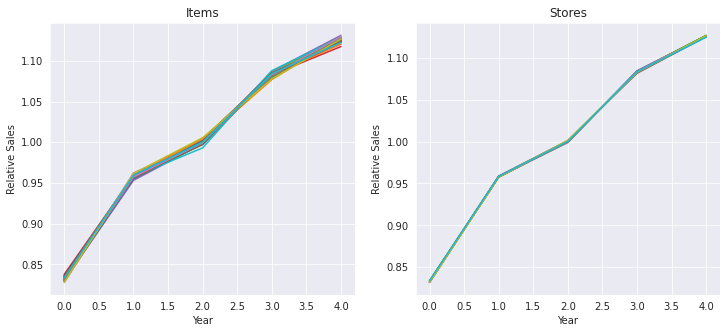

In [10]:
#Sales by year

agg_year_item = pd.pivot_table(train_df, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train_df, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()


We can see that the Items and Stores have grown similarly over the time.



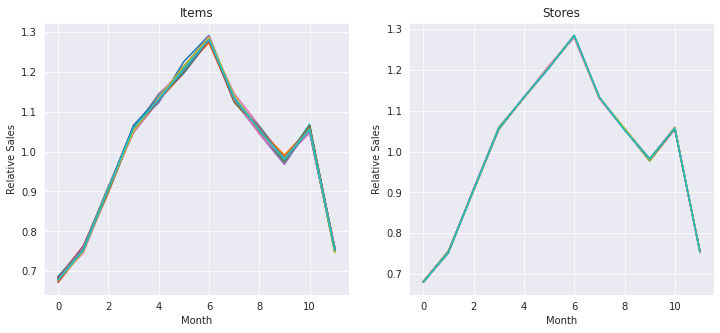

In [11]:
# Now lets check the sales w.r.t. the month

agg_month_item = pd.pivot_table(train_df, index='month', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train_df, index='month', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()


Sales by month has also shown similar growth pattern for both items and sales.



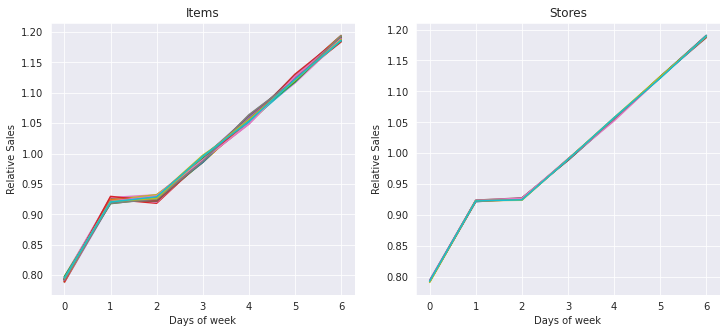

In [12]:
#Sales by days of week

agg_weekly_item = pd.pivot_table(train_df, index='dayofweek', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_weekly_store = pd.pivot_table(train_df, index='dayofweek', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_weekly_item / agg_weekly_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Days of week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_weekly_store / agg_weekly_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Days of week")
plt.ylabel("Relative Sales")
plt.show()


Sales by week has also shown similar growth pattern for both items and sales.


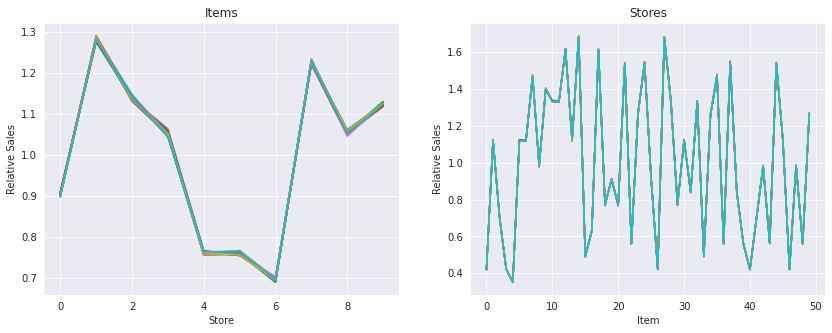

In [13]:
#Also now lets check for item store relationship

agg_store_item = pd.pivot_table(train_df, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()

Now we have checked the relationships between different variables.

It's time for us to decompose the time series

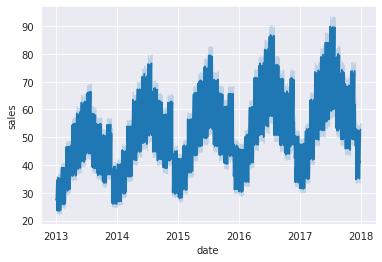

In [14]:
sns.lineplot(x="date",y="sales",legend="full",data=train_df)

Here we can see that sales with respect to date is time series data.

# Decompose the time series:

Time series data can exhibit a variety of patterns, and it is often helpful to split a time series into several components, each representing an underlying pattern category. When we decompose a time series into components, we usually combine the trend and cycle into a single trend-cycle component (sometimes called the trend for simplicity). Thus we think of a time series comprising three components: a trend-cycle component, a seasonal component, and a remainder component (containing anything else in the time series).




The Seasonal component: A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. A time series can contain multiple superimposed seasonal periods.

The Trend component: A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes a trend is referred to as “changing direction” when it might go from an increasing trend to a decreasing trend.

The Cyclical component: The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. The cyclical component is hard to isolate and it's often ‘left alone’ by combining it with the trend component.
The Noise component: The noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns.



<Figure size 432x288 with 0 Axes>

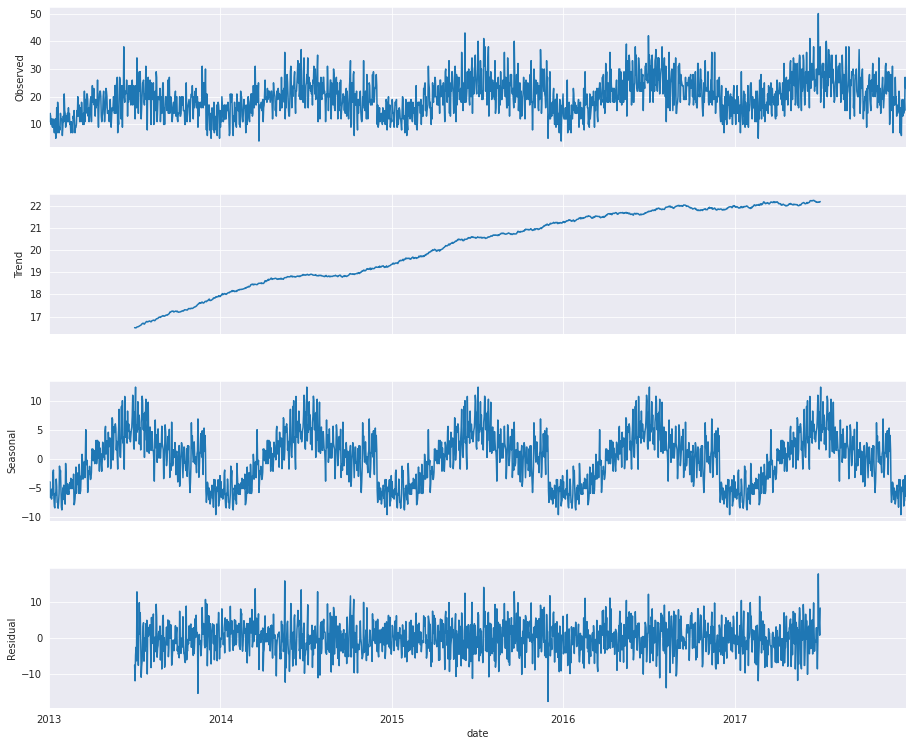

In [15]:
# Lets decompose for data of smaller size. Here I will take data having item and store equal to 1.

train_item1 = train_df[train_df['item']==1]
train_final = train_item1[train_item1['store']==1]

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_final['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

How to determine additive or multiplicative model for decomposition?
We use multiplicative models when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. On other hand, in the additive model, the magnitude of seasonality does not change in relation to time.

Depending on whether the composition is multiplicative or additive, we’ll need to divide or subtract the trend component from the original time series to retrieve the seasonal and noise components.


# XGB Regression

In [16]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [17]:
model_sets=[]
for max_depth in range(4,10,3):
  xgb_model = xgb.XGBRegressor(max_depth=max_depth ,min_child_weight=1)
#xgb_model.fit(X_train,y_train,eval_metric='mae')
  xgb_model.fit(X_train,y_train.values,eval_metric=smape)
  model_sets.append(xgb_model)
  
  y_train_pred_xgb=xgb_model.predict(X_train)
  y_test_pred_xgb=xgb_model.predict(X_test)
  print('smape error: max_depth=', max_depth ,',train:' , smape(y_train.values,y_train_pred_xgb),'test:',smape(y_test.values,y_test_pred_xgb))
  print('MSE train:' , mean_absolute_error(np.log1p(y_train),np.log1p(y_train_pred_xgb)),'test:',mean_absolute_error(np.log1p(y_test),np.log1p(y_test_pred_xgb)))

[21:28:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 4 ,train: 14.023779081082912 test: 14.044596595726162
MSE train: 0.13701588038833143 test: 0.137220589521824
[21:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
smape error: max_depth= 7 ,train: 13.180882401436516 test: 13.292679475020229
MSE train: 0.1286502889655606 test: 0.12976239888950494


# Stationarity

Before applying any statistical model on a Time Series, the series has to be stationary or time invariant, which means that, over different time periods, it should have constant means, constant variance and constant covariance. It means that the data should have constant mean throughout, scattered consistently and should have same frequency throughout. So, if our data mean, variance and covariance is varied with time then our data is non-stationary and we have to make it stationary before applying any method. This is necessary because if our data has some regular pattern then there’s a high probability that over a different interval, it will have same behavior and can cause problem in accuracy of model. And also, mathematical computation for stationary data is easier as compared to that of non-stationary data.



Lets check the stationarity
Here we are going to check the stationarity using 2 methods:

1. Rolling Mean: Plot the moving average or moving standard deviation to see if it varies with time.

2. ADCF Test — Augmented Dickey–Fuller test: This is used to gives us various values that can help in identifying stationarity. The Null hypothesis says that a Time-series is non-stationary. It comprises of a Test Statistics & some critical values for some confidence levels. If the Test statistics is less than the critical values, we can reject the null hypothesis & say that the series is stationary. The ADCF test also gives us a p-value. According to the null hypothesis, lower values of p is better.

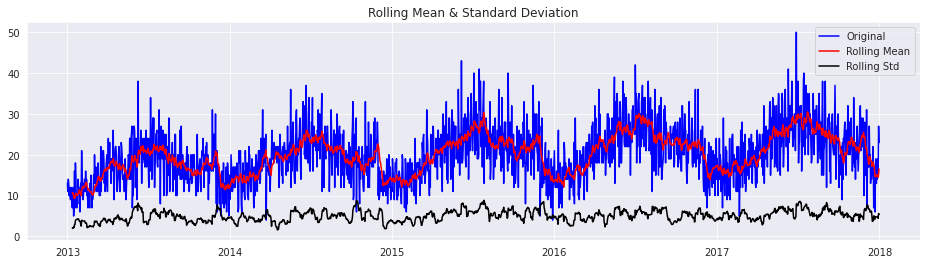

In [18]:
# Rolling Mean Analysis

def roll_stats(timeseries, window = 12, cutoff = 0.01):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(16, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
   # plt.rcParams['agg.path.chunksize'] = 50000
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
roll_stats(train_final['sales'])    

In [19]:
# Perform Dickey-Fuller test
def dickey_fuller_test(timeseries, window = 12, cutoff = 0.01):
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)
    
dickey_fuller_test(train_final['sales'])    

p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [20]:
# Make the time series stationary

first_diff = train_final.sales - train_final.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
print(first_diff.head())

date
2013-01-02   -2.0
2013-01-03    3.0
2013-01-04   -1.0
2013-01-05   -3.0
2013-01-06    2.0
Name: sales, dtype: float64


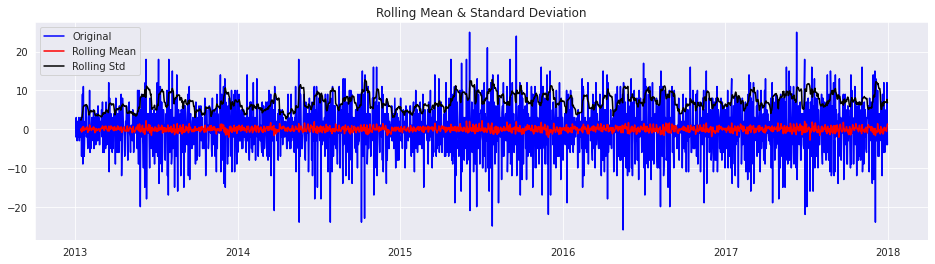

p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [21]:

roll_stats(first_diff,window = 12, cutoff = 0.01)
dickey_fuller_test(first_diff, window = 12)


As we can see that the time series is stationary now.



Lets start with ACF and PACF:

ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence band and tada! We have an ACF plot. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.



Now let’s see what is an AR and MA time series process:

Auto regressive (AR) process , a time series is said to be AR when present value of the time series can be obtained using previous values of the same time series i.e the present value is weighted average of its past values. Stock prices and global temperature rise can be thought of as an AR processes. The AR process of an order p can be written as,






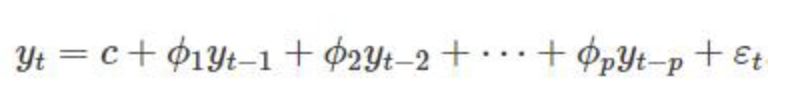

Where ϵt is a white noise and y’t-₁ and y’t-₂ are the lags. Order p is the lag value after which PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

Moving average (MA) process, a process where the present value of series is defined as a linear combination of past errors. We assume the errors to be independently distributed with the normal distribution. The MA process of order q is defined as ,





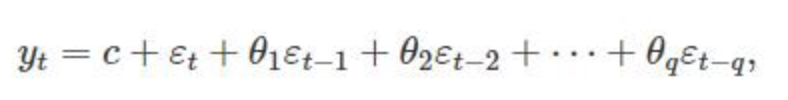

Here ϵt is a white noise. To get intuition of MA process lets consider order 1 MA process which will look like,






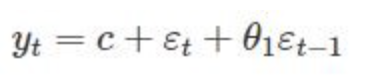

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time.

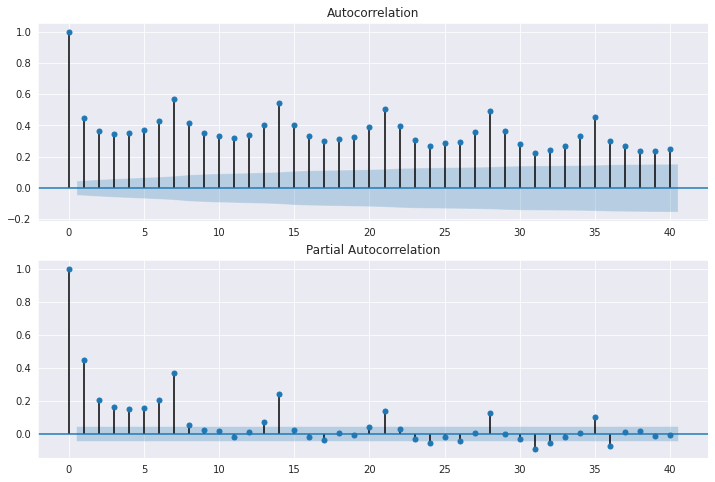

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_final.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_final.sales, lags=40, ax=ax2)# , lags=40

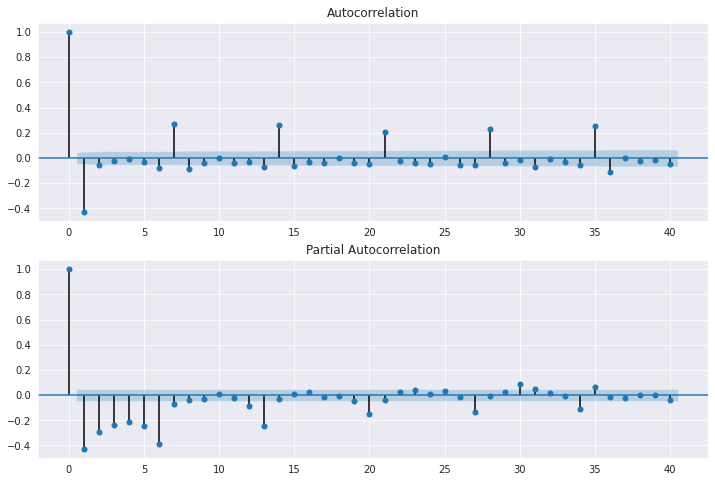

In [23]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

# ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q

where,

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)


How to find the order of the AR term (p)

You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

In [24]:
arima_model = sm.tsa.ARIMA(train_final.sales, (6,1,0)).fit(disp=False)
print(arima_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Tue, 15 Jun 2021   AIC                          11211.335
Time:                        21:31:03   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

NormaltestResult(statistic=16.42638821418894, pvalue=0.0002710535630199733)


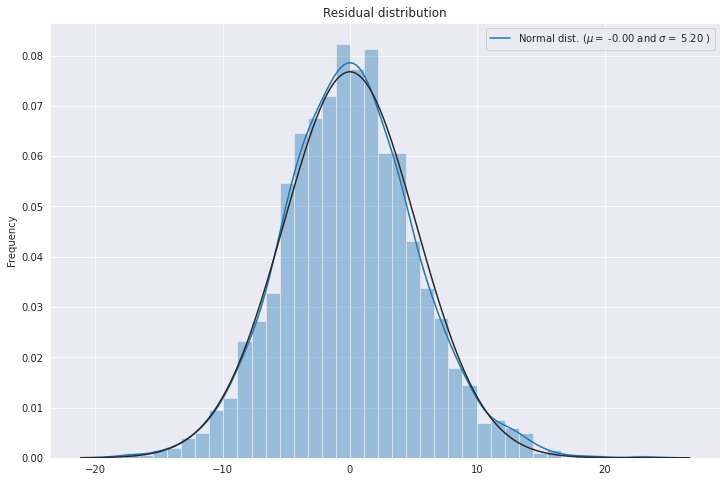

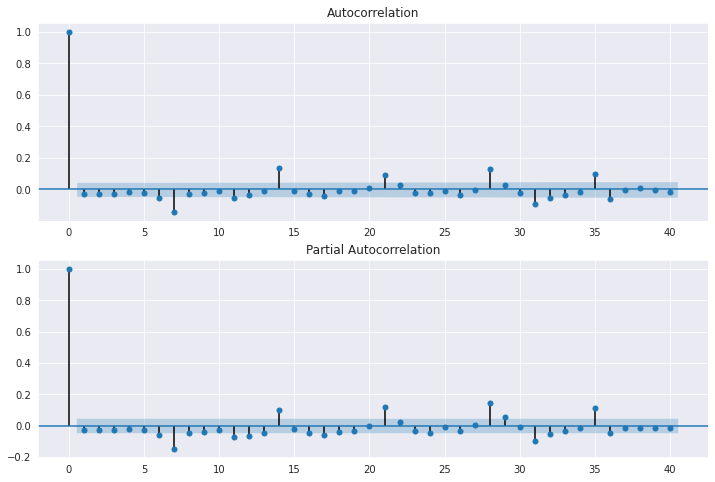

In [25]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_model.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=40, ax=ax2)

# Prediction using ARIMA Model


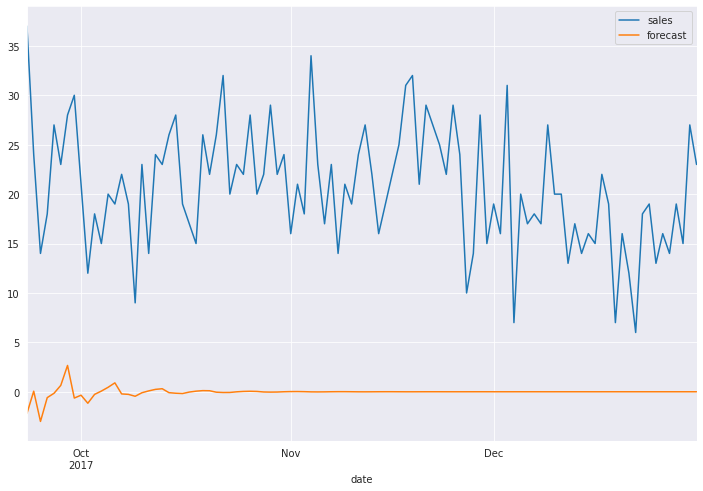

In [26]:
start_index = 1726
end_index = 1826
train_df['forecast'] = arima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))


Clearly we can see that there is some problem with this model. So let's try with some different model.



In [27]:
# Now we will use SARIMAX

sarima_model = sm.tsa.statespace.SARIMAX(train_final.sales, trend='n', order=(6,1,0)).fit()
print(sarima_model.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Tue, 15 Jun 2021   AIC                          11209.359
Time:                        21:31:05   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

NormaltestResult(statistic=16.742690148319554, pvalue=0.00023140408865311604)


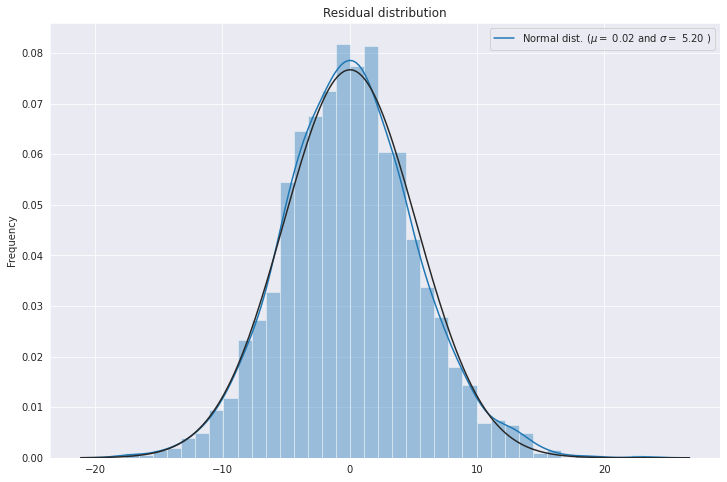

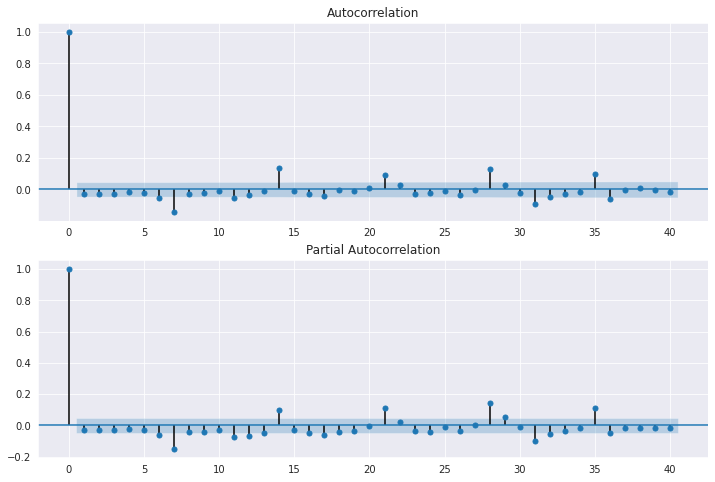

In [28]:
resid = sarima_model.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_model.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_model.resid, lags=40, ax=ax2)


# Prediction using SARIMAX

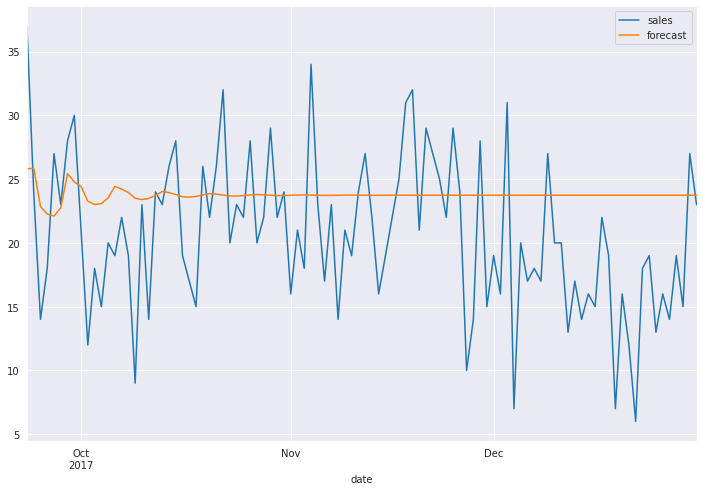

In [29]:
start_index = 1726
end_index = 1826
train_df['forecast'] = sarima_model.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

We can see that this model is better than simple ARIMA model.



# XGB model